In [1]:
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('train_final.parquet/train_final.parquet')

In [4]:
df.head()

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.197737,1.113360,-1.123334,...,-2.613336,-2.032903,2.645719,-1.023478,1.658986,-1.559406,-2.161336,30,58,"menu2, menu4, menu5"
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,samsung,-2.336352,2.567766,-0.494908,...,-0.983938,-1.453756,-0.021547,-0.195770,2.775513,-0.318980,-4.291473,21,45,"menu7, menu8, menu4"
2,c82a7cbd2e00d9b66c06bcadc,10,3835.618,3275.128,43.806,TURK TELEKOM,Redmi,-2.561455,2.061736,-0.184511,...,-1.668703,-3.599403,1.673868,0.631790,1.293131,-2.230909,-2.383524,19,61,"menu2, menu8, menu4"
3,f2d2b25073ccc298eced86897,10,3532.544,154.509,64.724,TURKCELL,samsung,-2.529918,3.358050,-0.851366,...,-1.861418,-1.219658,1.863495,0.213170,1.029710,-1.142185,-4.466191,2,41,"menu6, menu2, menu1"
4,7818c92a58af0f2cb7c361738,10,3344.192,787.896,715.115,VODAFONE TR,samsung,-2.922361,2.096124,0.060796,...,-0.142903,-1.875545,1.024499,-0.186423,-0.061626,-1.462175,-2.371206,23,85,"menu6, menu2, menu8"


In [5]:
# check for missing data
df.isnull().any().any()

False

In [6]:
df = df.assign(menu1=np.zeros(df.shape[0]),
         menu2=np.zeros(df.shape[0]),
         menu3=np.zeros(df.shape[0]),
         menu4=np.zeros(df.shape[0]),
         menu5=np.zeros(df.shape[0]),
         menu6=np.zeros(df.shape[0]),
         menu7=np.zeros(df.shape[0]),
         menu8=np.zeros(df.shape[0]),
         menu9=np.zeros(df.shape[0])
        )

In [7]:
for row_number in range(df.shape[0]):
    row_to_insert = np.zeros(9)
    list_of_menus = df.loc[row_number]['target'].split(', ')
    menu_number = [int(menu[-1]) for menu in list_of_menus]
    row_to_insert[np.array([menu_number])-1] = 1
    df.iloc[row_number, -9:] = row_to_insert

In [8]:
# check whether the row-based sum of menu1-menu9 is 3

(df.iloc[:,-9:].sum(axis=1) == 3).all()

True

In [9]:
df = df.drop(columns = ['id', 'target'])

In [10]:
# check for row-based duplicates

df.drop_duplicates()
df.shape

(94049, 65)

In [11]:
target_list=df.columns.values[-9:]

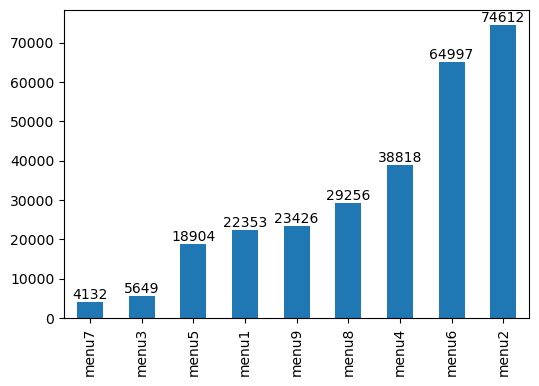

In [12]:
# check target distribution

plt.figure(figsize=(6,4))
a = df[target_list].sum().sort_values().plot.bar()
plt.bar_label(a.containers[0])
plt.show()

In [13]:
# data type check

df.dtypes.value_counts()

float64    60
int64       3
object      2
Name: count, dtype: int64

In [14]:
# data type check

df.select_dtypes(exclude = 'float64')

,month,carrier,devicebrand,feature_48,feature_49
0,10,VODAFONE TR,Apple,30,58
1,10,TURKCELL,samsung,21,45
2,10,TURK TELEKOM,Redmi,19,61
3,10,TURKCELL,samsung,2,41
4,10,VODAFONE TR,samsung,23,85
...,...,...,...,...,...
94044,12,O2 - DE,HUAWEI,29,68
94045,12,TURKCELL,samsung,25,43
94046,12,VODAFONE TR,Apple,4,25
94047,12,TURK TELEKOM,Redmi,25,60


In [15]:
df.select_dtypes(include = 'object')

,carrier,devicebrand
0,VODAFONE TR,Apple
1,TURKCELL,samsung
2,TURK TELEKOM,Redmi
3,TURKCELL,samsung
4,VODAFONE TR,samsung
...,...,...
94044,O2 - DE,HUAWEI
94045,TURKCELL,samsung
94046,VODAFONE TR,Apple
94047,TURK TELEKOM,Redmi


In [16]:
# change the target columns' data types to reduce memory consumption

df[target_list] = df[target_list].astype(np.int8)

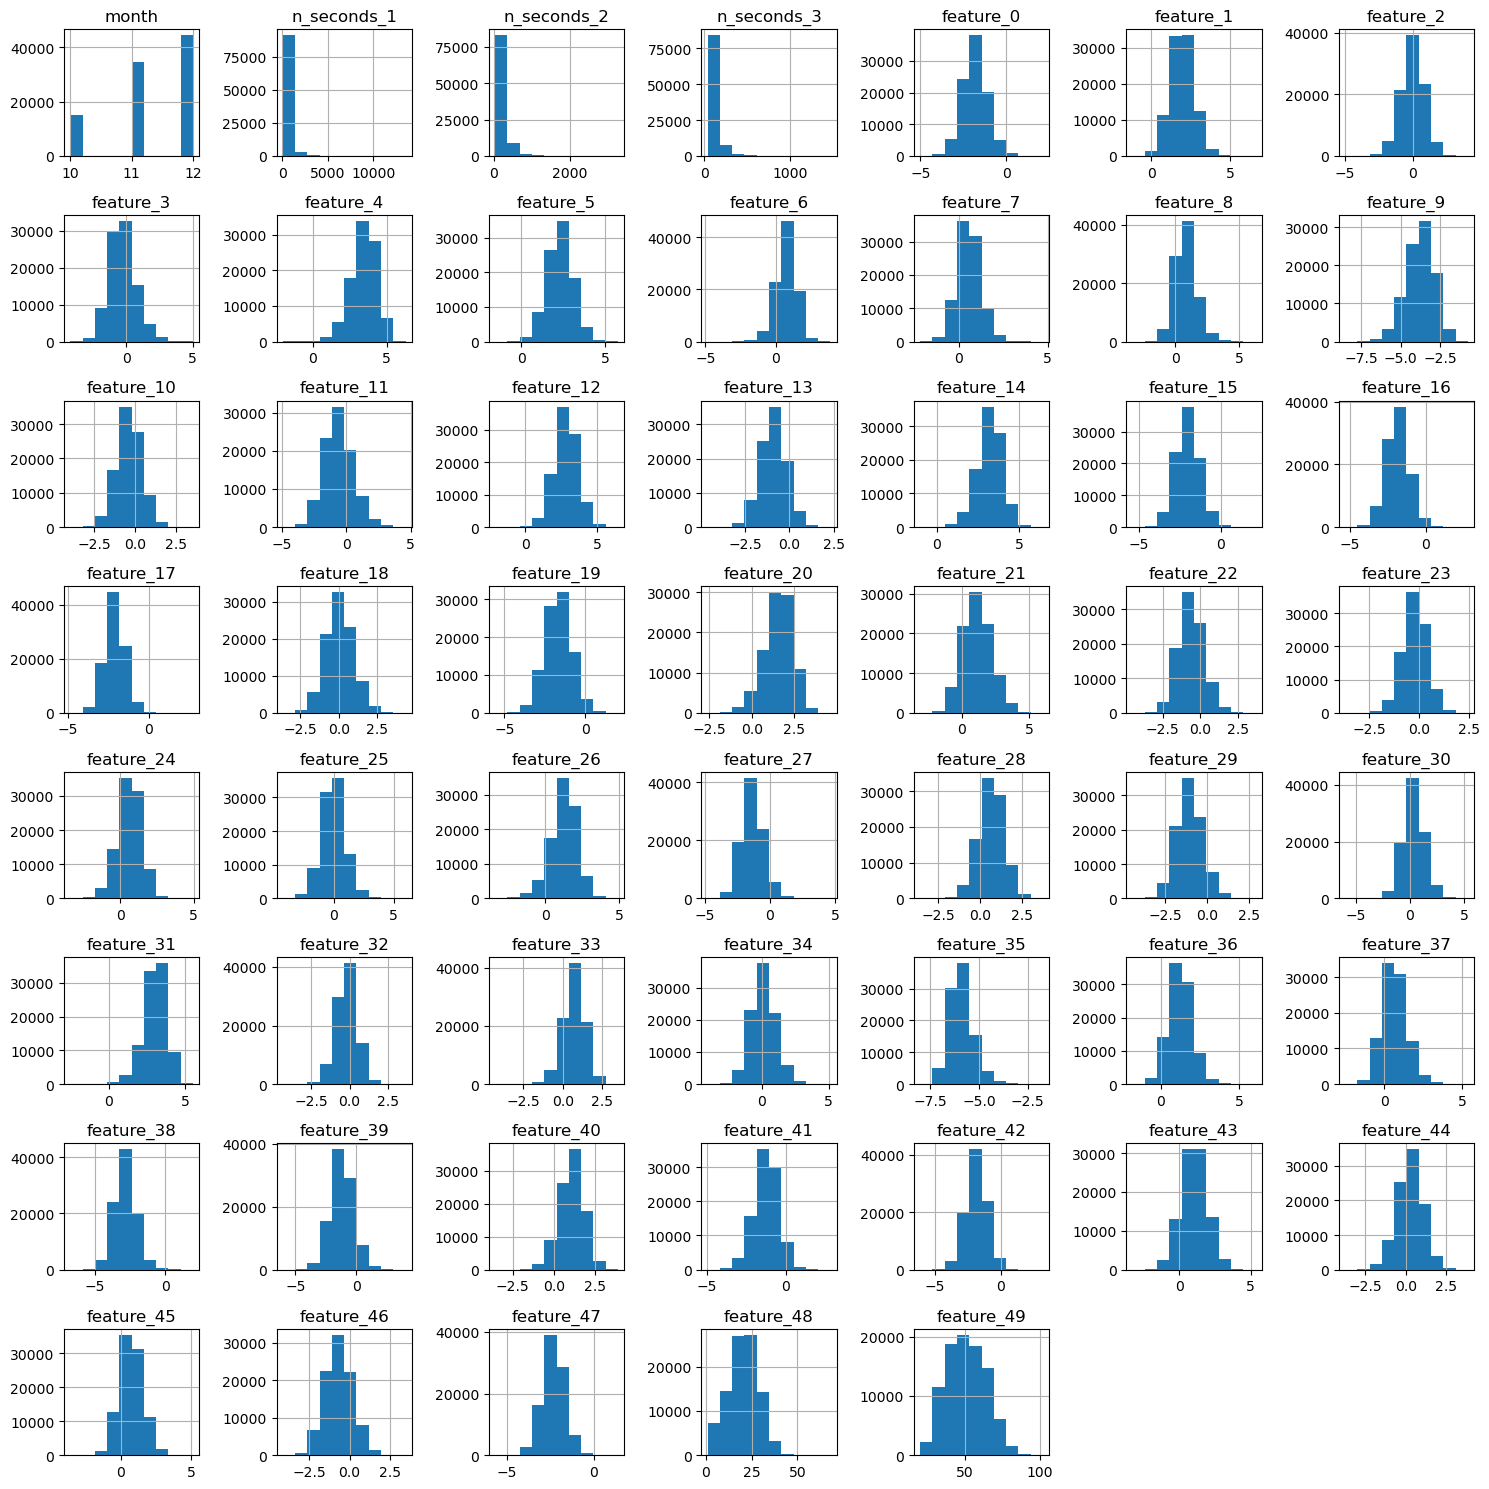

In [17]:
# check distribution of features

df.hist(column = df.columns[0:-9].tolist(), figsize = (15,15))
plt.tight_layout()
plt.show()

In [18]:
from sklearn.preprocessing import PowerTransformer

# temporary feature distribution check. transformations will be done using pipeline later on.

pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_copy = df.copy()
df_copy.drop(columns = ['devicebrand', 'carrier'], inplace = True)
df_copy_trans = pt.fit_transform(df_copy)

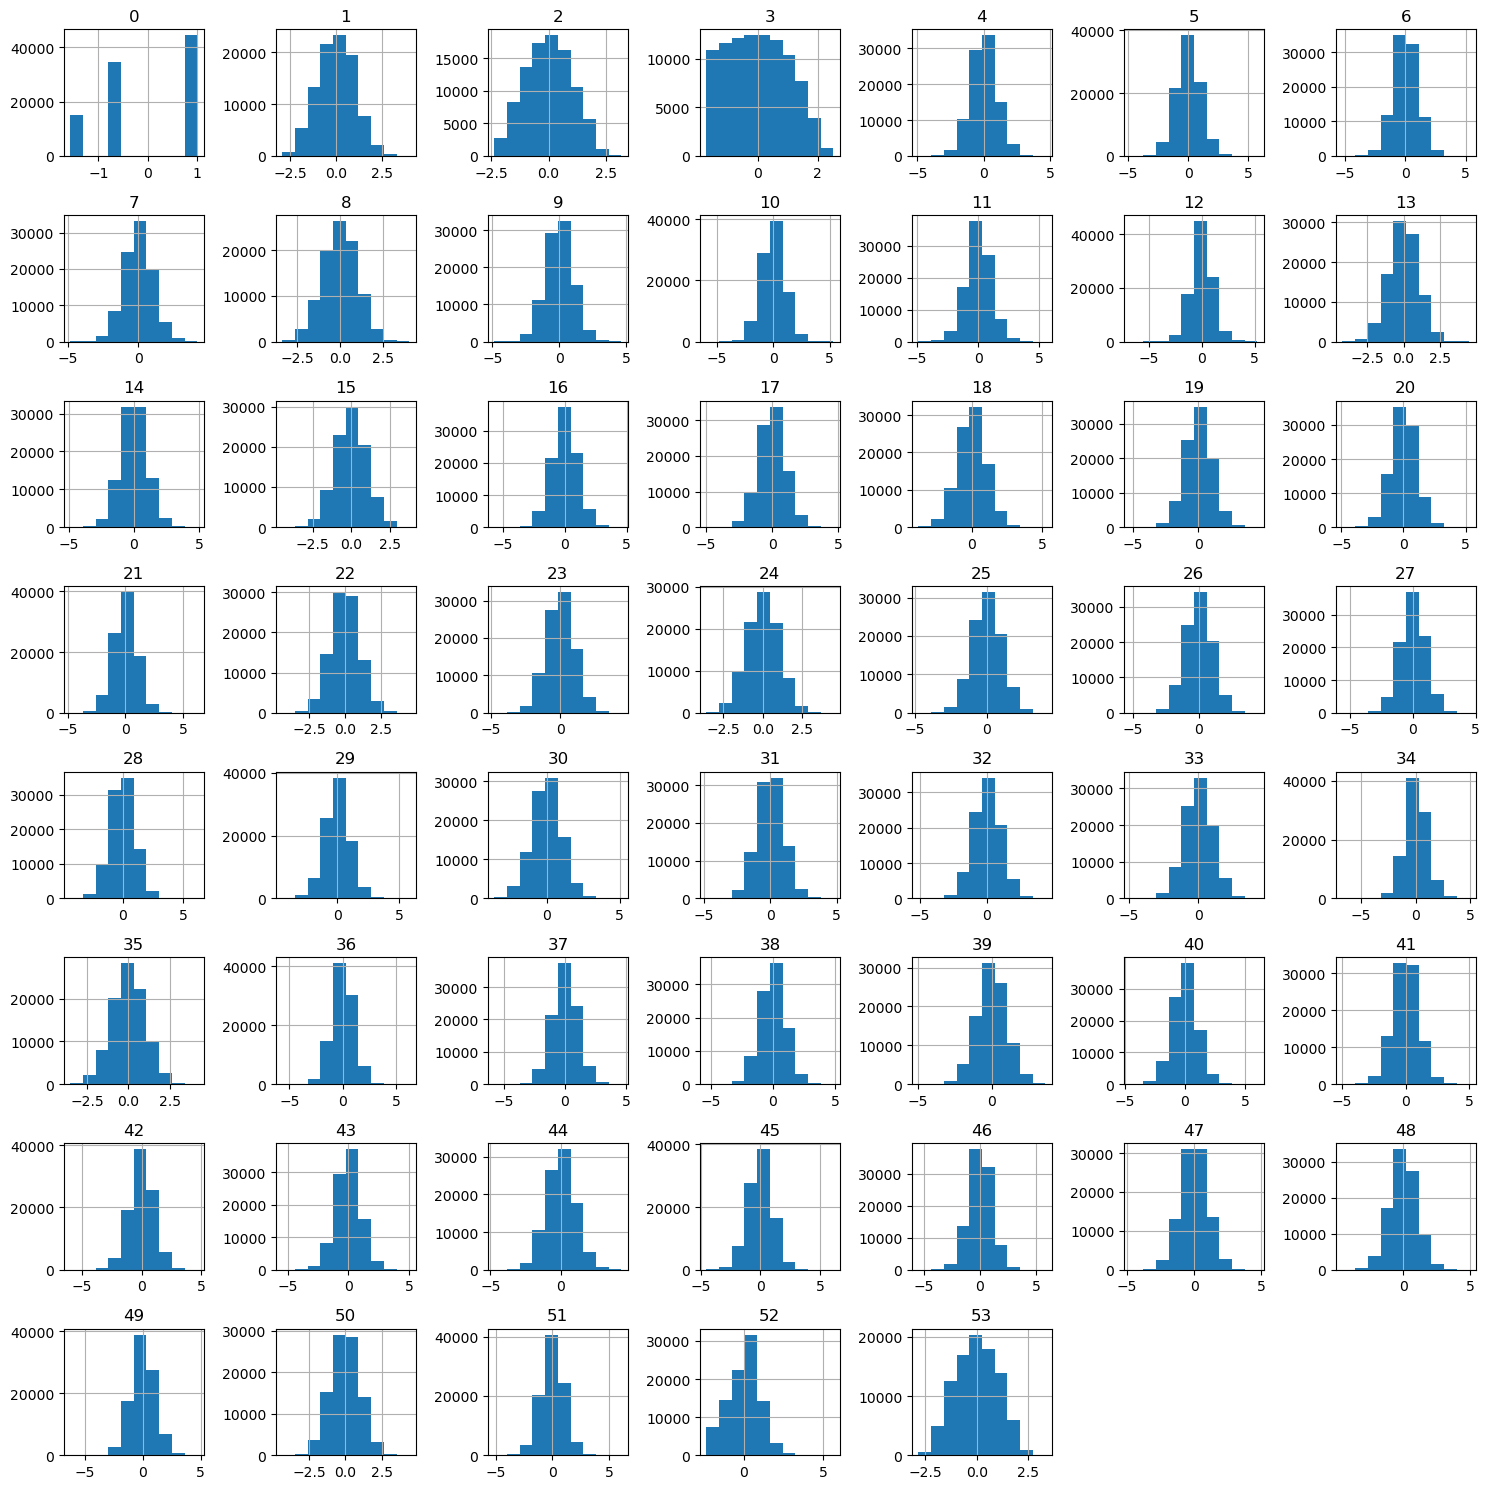

In [19]:
# check feature distributions after power transform

df_copy_trans = pd.DataFrame(df_copy_trans)
df_copy_trans.hist(column = df_copy_trans.columns[0:-9].tolist(), figsize = (15,15))
plt.tight_layout()
plt.show()

### OUTLIER DETECTION

#### UNIVARIATE OUTLIER ELIMINATION

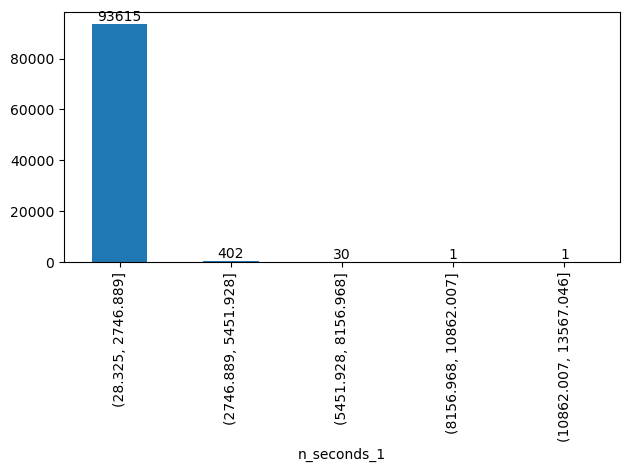

In [20]:
a = pd.cut(df.n_seconds_1, bins = 5).value_counts().sort_index().plot.bar()
plt.bar_label(a.containers[0])
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats.mstats import winsorize

df_no_outliers = df.copy()
columns_to_winsorize = list(df.columns[1:4]) + list(df.columns[6:-9])
for feature in df_no_outliers[columns_to_winsorize]:
    winsorized = winsorize(df[feature], limits = (0.01, 0.01))
    df_no_outliers.loc[df_no_outliers.index, feature] = winsorized



In [22]:
df.query("n_seconds_1 < 2200").shape[0]

93164

In [23]:
(df_no_outliers[['carrier']].value_counts() == 1).sum()

295

In [24]:
pd.options.display.max_rows = 999

In [25]:
df_no_outliers[['carrier']].value_counts().head(999)

carrier                          
TURKCELL                             39043
VODAFONE TR                          25583
TURK TELEKOM                         22091
BIMCELL                               1108
Unknown                                684
KKTCELL                                659
VODAFONE                               560
HAYATEVESIGAR                          559
TEKNOSACELL                            498
PTTCELL                                423
LIFECELL TR                            177
FENERCELL                              136
VODAFONE.DE                            102
TR TURKCELL                             97
O2-DE                                   90
AVEA                                    84
GSMOBILE                                81
CARRIER                                 77
T-MOBILE                                62
VODAFONE UK                             59
ELUX                                    56
CUMHURIYET                              49
TEKNOSA             

In [26]:
pd.options.display.max_rows = 60

In [27]:
wdf = pd.DataFrame(df_no_outliers[['carrier']].value_counts()[df_no_outliers[['carrier']].value_counts() <= 6])
wdf

,count
carrier,
IAM,6
STC KSA,6
A1 SRB,6
O2,6
T-MOBILE NL,6
...,...
MAGENTA-T-,1
M:TEL | GSMOBILE,1
LINA,1


In [28]:
wdf.reset_index(inplace = True)

In [29]:
#wdf_index = df_no_outliers[df['carrier'].isin(wdf['carrier'])].index
#wdf_index

In [30]:
gwg = list(wdf['carrier'])

In [31]:
df_no_outliers['carrier'].replace(gwg, 'Other', inplace = True)

In [32]:
df_no_outliers['carrier'].value_counts()

carrier
TURKCELL        39043
VODAFONE TR     25583
TURK TELEKOM    22091
BIMCELL          1108
Other             802
                ...  
SFR                 7
VIVACOM             7
KOREK               7
WEBBING             7
VODAFONE IE         7
Name: count, Length: 90, dtype: int64

In [33]:
#df_no_outliers.drop(wdf_index, inplace = True)

In [34]:
pd.options.display.max_rows = 999
df_no_outliers[['devicebrand']].value_counts().head(999)

devicebrand  
Apple            33238
samsung          31971
Redmi             7709
HUAWEI            6595
xiaomi            5300
OPPO              3247
POCO               989
GM                 770
realme             562
lge                442
TECNO              296
Casper             278
HONOR              264
Vestel             261
vivo               239
reeder             220
Sony               216
OnePlus            185
Lenovo             181
gm                 178
asus               156
TCL                151
OMIX               114
Infinix             65
Nokia               57
google              53
Meizu               49
motorola            31
htc                 21
Alcatel             21
ZTE                 18
Realme              16
OUKITEL             14
TURKCELL            14
CASPER              13
HIKING              13
Reeder              12
generalmobile       11
meizu                7
HTC                  7
Trident              6
Elephone             5
HiKING              

In [35]:
pd.options.display.max_rows = 60

In [36]:
wdf = pd.DataFrame(df_no_outliers[['devicebrand']].value_counts()[df_no_outliers[['devicebrand']].value_counts() <= 7])
wdf

,count
devicebrand,
meizu,7
HTC,7
Trident,6
Elephone,5
HiKING,5
blackberry,5
Huawei,5
Turk_Telekom,5
Ulefone,4


In [37]:
wdf.reset_index(inplace = True)

In [38]:
gwg = list(wdf['devicebrand'])

In [39]:
df_no_outliers['devicebrand'].replace(gwg, 'Other', inplace = True)

In [40]:
#wdf_index = df_no_outliers[df['devicebrand'].isin(wdf['devicebrand'])].index

In [41]:
#df_no_outliers.drop(wdf_index, inplace = True)

In [42]:
df_no_outliers[['devicebrand']].value_counts()

devicebrand  
Apple            33238
samsung          31971
Redmi             7709
HUAWEI            6595
xiaomi            5300
OPPO              3247
POCO               989
GM                 770
realme             562
lge                442
TECNO              296
Casper             278
HONOR              264
Vestel             261
vivo               239
reeder             220
Sony               216
OnePlus            185
Lenovo             181
gm                 178
asus               156
TCL                151
OMIX               114
Other               79
Infinix             65
Nokia               57
google              53
Meizu               49
motorola            31
htc                 21
Alcatel             21
ZTE                 18
Realme              16
TURKCELL            14
OUKITEL             14
CASPER              13
HIKING              13
Reeder              12
generalmobile       11
Name: count, dtype: int64

#### MULTIVARIATE OUTLIER ELIMINATION

In [43]:
cols_for_mvo_elim = list(df.columns[1:4]) + list(df.columns[6:-9])
wdf = (df_no_outliers[cols_for_mvo_elim] - df_no_outliers[cols_for_mvo_elim].min())/(df_no_outliers[cols_for_mvo_elim].max()-df_no_outliers[cols_for_mvo_elim].min())

In [44]:
from sklearn.ensemble import IsolationForest

auto_detection = IsolationForest(max_samples = 'auto', contamination = 0.005, random_state = 0, n_jobs = -1)
auto_detection.fit(wdf)
evaluation = auto_detection.predict(wdf)
suspected_outliers = df_no_outliers[evaluation == -1]

In [45]:
df_no_outliers.drop(index = suspected_outliers.index.tolist(), inplace = True)
df_no_outliers.shape

(93578, 65)

### FEATURE SELECTION and TRANSFORMATION

In [46]:
print(pd.options.display.max_rows, pd.options.display.max_columns)

60 20


In [47]:
# check correlation matrix

pd.options.display.max_rows = 63
pd.options.display.max_columns = 63

numerical_features = list(df.columns[0:4]) + list(df.columns[6:-9])

corr_table = df_no_outliers[numerical_features].corr(method = 'pearson')
BM = (corr_table > 0.2) | (corr_table < -0.2) # 0.7 degeri icin kontrol edildiginde hicbir korelasyon degeri bu degeri asmiyor.
corr_table[BM]

,month,n_seconds_1,n_seconds_2,n_seconds_3,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
month,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.215278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249246,NaN,NaN,NaN,NaN,NaN,-0.237638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.218905,0.200116,-0.214343,-0.359650,NaN,NaN,NaN,NaN
n_seconds_1,NaN,1.000000,0.630178,0.39983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_seconds_2,NaN,0.630178,1.000000,0.64035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_seconds_3,NaN,0.399830,0.640350,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.226846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.213847,NaN,-0.248432,NaN,NaN,NaN,NaN,NaN,-0.228829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.268038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_1,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.215629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204234,NaN,NaN,-0.295309,NaN,-0.245882,NaN,NaN,NaN,-0.230103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.415704,NaN,NaN,NaN,0.244255,NaN,NaN,NaN,NaN,NaN,NaN
feature_2,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.230216,NaN,NaN,NaN,NaN,-0.216865,0.367349,-0.297932,NaN,NaN,0.276883,NaN,-0.243669,NaN,NaN,-0.236726,-0.295981,0.361034,-0.316477,NaN,-0.207550,NaN,0.301908,NaN,-0.201700,NaN,-0.238615,-0.304192,NaN,NaN,NaN,-0.243448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.313104,-0.377250,0.231847,NaN,NaN,NaN,0.249485,0.265627
feature_3,0.215278,NaN,NaN,NaN,NaN,0.215629,-0.230216,1.000000,-0.326973,NaN,NaN,NaN,0.440165,-0.432772,0.283934,0.295153,NaN,NaN,NaN,NaN,-0.214400,NaN,NaN,0.240412,-0.393238,0.376174,NaN,NaN,NaN,-0.304507,-0.374700,NaN,NaN,NaN,NaN,-0.230163,NaN,NaN,NaN,NaN,-0.337673,0.384573,NaN,NaN,NaN,NaN,-0.309380,0.311296,-0.255567,NaN,NaN,NaN,NaN,NaN
feature_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.326973,1.000000,NaN,NaN,-0.240805,-0.391145,0.461344,NaN,-0.254459,-0.286877,NaN,NaN,NaN,NaN,NaN,-0.311886,NaN,0.302196,-0.357402,-0.262513,NaN,0.370041,NaN,NaN,NaN,-0.203757,-0.214077,NaN,0.263306,NaN,0.413726,-0.274428,NaN,0.216576,-0.458046,NaN,NaN,0.282223,0.295999,NaN,-0.334811,0.233247,NaN,0.200802,NaN,NaN,NaN
feature_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.301878,NaN,0.215673,0.429430,NaN,NaN,-0.212328,NaN,NaN,NaN,-0.346141,NaN,-0.220091,NaN,NaN,NaN,NaN,-0.220491,-0.245964,NaN,NaN,-0.253342,NaN,NaN,NaN,NaN,NaN,NaN,-0.241298,NaN,NaN,-0.209428,NaN,NaN,NaN,NaN,-0.331354,NaN,NaN,NaN,NaN,NaN


In [48]:
corr_table = df_no_outliers[numerical_features].corr(method = 'spearman')
BM = (corr_table > 0.2) | (corr_table < -0.2) # 0.7 degeri icin kontrol edildiginde hicbir korelasyon degeri bu degeri asmiyor.
corr_table[BM]

,month,n_seconds_1,n_seconds_2,n_seconds_3,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
month,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.214615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258251,NaN,NaN,NaN,NaN,NaN,-0.236530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.203484,NaN,-0.216471,-0.354874,NaN,NaN,NaN,NaN
n_seconds_1,NaN,1.000000,0.671758,0.433279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_seconds_2,NaN,0.671758,1.000000,0.653665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_seconds_3,NaN,0.433279,0.653665,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.209420,NaN,-0.227101,NaN,NaN,NaN,NaN,NaN,-0.215168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.243515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_1,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.214646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.287013,NaN,-0.255067,NaN,NaN,NaN,-0.223040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.404599,NaN,NaN,NaN,0.240102,NaN,NaN,NaN,NaN,NaN,NaN
feature_2,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.210658,NaN,NaN,NaN,NaN,-0.208393,0.346224,-0.297552,NaN,NaN,0.264727,NaN,-0.232104,NaN,NaN,-0.220811,-0.289532,0.342900,-0.299837,NaN,-0.202657,NaN,0.298101,NaN,NaN,NaN,-0.222539,-0.300047,NaN,NaN,NaN,-0.235839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.302383,-0.366401,0.227992,NaN,NaN,NaN,0.245321,0.261499
feature_3,0.214615,NaN,NaN,NaN,NaN,0.214646,-0.210658,1.000000,-0.305311,NaN,NaN,NaN,0.398635,-0.405569,0.266230,0.260122,NaN,NaN,NaN,NaN,-0.224477,NaN,NaN,0.231638,-0.373130,0.348640,NaN,NaN,NaN,-0.283340,-0.319982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.331025,0.354003,NaN,NaN,NaN,NaN,-0.304423,0.318632,-0.239061,NaN,NaN,NaN,NaN,NaN
feature_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.305311,1.000000,NaN,NaN,-0.219942,-0.365298,0.437506,NaN,-0.226582,-0.295119,NaN,NaN,NaN,NaN,NaN,-0.306352,NaN,0.275998,-0.336453,-0.251156,NaN,0.362552,NaN,NaN,NaN,-0.222141,-0.202612,NaN,0.232273,NaN,0.398901,-0.258545,NaN,0.231548,-0.444334,NaN,NaN,0.267579,0.292325,NaN,-0.332796,0.212149,NaN,0.209878,NaN,NaN,NaN
feature_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.292124,NaN,0.203296,0.416472,NaN,NaN,-0.203179,NaN,NaN,NaN,-0.338862,NaN,-0.217223,NaN,NaN,NaN,NaN,-0.218855,-0.230874,NaN,NaN,-0.243544,NaN,NaN,NaN,NaN,NaN,NaN,-0.233708,NaN,NaN,-0.207849,NaN,NaN,NaN,NaN,-0.321255,NaN,NaN,NaN,NaN,NaN


In [49]:
# judging from the two tables above PCA may not be needed since there aren't strong correlations (>0.7 and <-0.7)
# but lets use PCA regardless.

In [50]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20

In [51]:
df_no_outliers_cat_encoded = pd.get_dummies(data = df_no_outliers, columns = ['carrier', 'devicebrand'], dtype = float)

In [52]:
from sklearn.preprocessing import MinMaxScaler

df_no_outliers_cat_encoded_copy = df_no_outliers_cat_encoded.copy()
df_no_outliers_cat_encoded_copy_trans = pt.fit_transform(df_no_outliers_cat_encoded_copy)
scaler = MinMaxScaler()
df_no_outliers_cat_encoded_copy_trans_2 = scaler.fit_transform(df_no_outliers_cat_encoded_copy_trans)

In [53]:
from sklearn.decomposition import PCA

pca = PCA()
Xs = pd.DataFrame(df_no_outliers_cat_encoded_copy_trans_2).iloc[:, 0:-9]
pca.fit(Xs)
Xs_t = pd.DataFrame(pca.transform(Xs), index = Xs.index)
Xs_t.columns = ['PC{}'.format(i) for i in range(1, Xs.shape[1]+1)]

In [54]:
total_var = Xs_t.var().sum()
dic = {'var_perc': Xs_t.var() / total_var,
       'cum_var_perc': Xs_t.var().cumsum() / total_var
      }
explanation_df = pd.DataFrame(dic)
explanation_df

,var_perc,cum_var_perc
PC1,7.556194e-02,0.075562
PC2,6.977719e-02,0.145339
PC3,6.335104e-02,0.208690
PC4,5.793544e-02,0.266626
PC5,5.074379e-02,0.317369
...,...,...
PC179,1.470691e-05,0.999975
PC180,1.273839e-05,0.999987
PC181,1.262761e-05,1.000000
PC182,1.291120e-27,1.000000


In [55]:
explanation_df.query("0.6 <= cum_var_perc <= 0.9")
# try components between this

,var_perc,cum_var_perc
PC13,0.023884,0.607321
PC14,0.023588,0.630909
PC15,0.021944,0.652852
PC16,0.017447,0.670299
PC17,0.015974,0.686273
PC18,0.015033,0.701306
PC19,0.014443,0.715749
PC20,0.013739,0.729488
PC21,0.012685,0.742173
PC22,0.012226,0.754400


In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from logitboost import LogitBoost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import jaccard_score
from sklearn.decomposition import TruncatedSVD 

In [58]:
estimators = [RandomForestClassifier(), GradientBoostingClassifier()]
estimator_names = ['RF', 'GBC']
initial_models = [MultiOutputClassifier(SVC(kernel = 'rbf', cache_size = 1000, probability = True)), # takes too much time
                  MultiOutputClassifier(CalibratedClassifierCV(LinearSVC()), n_jobs = -1), # takes too much time
                  MultiOutputClassifier(ExtraTreesClassifier(), n_jobs = -1),  
                  MultiOutputClassifier(LogisticRegression(n_jobs = -1), n_jobs = -1), 
                  MultiOutputClassifier(KNeighborsClassifier(n_jobs = -1), n_jobs = -1), 
                  MultiOutputClassifier(RandomForestClassifier(n_jobs = -1), n_jobs = -1),
                  MultiOutputClassifier(LinearDiscriminantAnalysis(), n_jobs = -1),
                  MultiOutputClassifier(QuadraticDiscriminantAnalysis(), n_jobs = -1),
                  MultiOutputClassifier(GradientBoostingClassifier(), n_jobs = -1),
                  MultiOutputClassifier(LogitBoost(), n_jobs = -1),
                  MultiOutputClassifier(LGBMClassifier(), n_jobs = -1),
                  MultiOutputClassifier(XGBClassifier(use_label_encoder = False, n_jobs = -1), n_jobs = -1),
                  MultiOutputClassifier(BaggingClassifier(estimator = RandomForestClassifier(), n_jobs = -1), n_jobs = -1),
                  MultiOutputClassifier(BaggingClassifier(estimator = ExtraTreesClassifier(), n_jobs = -1), n_jobs = -1)
                 ]
initial_models_names = ['SVM', 'Linear SVM', 'ET', 'LR', 'KNN', 'RF', 'LDA', 'QDA', 'GB', 'LB', 'LGBM', 'XGB', 'BC-rf', 'BC-et']

#df_no_outliers.drop(columns = ['carrier', 'devicebrand'], inplace = True)
#df_no_outliers[target_list] = df_no_outliers[target_list].astype(np.int8)
#X = df_no_outliers.values[:, 0:-9]
#y = df_no_outliers.values[:, -9:]

X = df_no_outliers.iloc[:, 0:-9]
y = df_no_outliers.iloc[:, -9:]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state = 5, test_size = 0.2, shuffle = True, stratify = y)

In [59]:
numerical_features = list(df_no_outliers.columns[0:4]) + list(df_no_outliers.columns[6:-9])
numerical_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

categorical_features = list(df_no_outliers.columns[4:6])
categorical_transformer = OneHotEncoder(drop = 'first')

preprocessor = ColumnTransformer(transformers = [('num', numerical_transformer, numerical_features),
                                                 ('cat', categorical_transformer, categorical_features)])

numerical_transformer_tsvd = Pipeline(steps = [('power_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
                                              ('normalization', MinMaxScaler())])
                                     
preprocessor_tsvd = ColumnTransformer(transformers = [('num_tsvd', numerical_transformer_tsvd, numerical_features),
                                                 ('cat_tsvd', categorical_transformer, categorical_features)])

In [60]:
def get_models():
    models = dict()
    for model_name, model in zip(initial_models_names, initial_models):
        for estimator_name, estimator in zip(estimator_names, estimators):
            rfecv = RFECV(estimator = estimator, cv = 3, step = 2, n_jobs = -1)
            models[model_name + ' with estimator: ' + estimator_name] = Pipeline(steps = [('preprocessor', preprocessor), ('rfecv', rfecv), ('model', model)])
    return models


def get_models_tsvd():
    models_tsvd = dict()
    for model_name, model in zip(initial_models_names, initial_models):
        for no_of_components in range(13,41,4): # tsvd components to be tried
            models_tsvd[model_name + ' TSVD with ' + str(no_of_components) + ' components'] = Pipeline(steps = [('preprocessor_tsvd', preprocessor_tsvd), ('t', TruncatedSVD(n_components = no_of_components)), ('model_tsvd', model)])
    return models_tsvd

def get_model_catboost():
    model_catboost = dict()
    model_catboost['CATBoost'] = MultiOutputClassifier(CatBoostClassifier(cat_features = categorical_features, early_stopping_rounds = 7), n_jobs = -1)
    return model_catboost

def evaluate_model(model, X, y):
    #adjusted_y = np.argmax(y, axis=1) #adjust y_train so repeated stratified kfold can use it
    #cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
    probabilities = cross_val_predict(model, X, y, cv = 5, method = 'predict_proba', n_jobs = -1)
    y_pred = np.empty([X.shape[0], 9], dtype = int)
    
    for i in range(0, X.shape[0]):
        a = np.array([probabilities[0][i][0], probabilities[1][i][0], probabilities[2][i][0], probabilities[3][i][0], 
                      probabilities[4][i][0], probabilities[5][i][0], probabilities[6][i][0], probabilities[7][i][0],
                    probabilities[8][i][0]])
        b = np.argsort(a)[0:3] # select first three lowest values
        zeros_array = np.zeros(shape = 9, dtype = int)
        row_to_append = np.put(zeros_array, list(b), 1) # change the referred row in zeroes_array with value 1
        y_pred[i] = zeros_array

    score = jaccard_score(y, y_pred, average = 'samples')
    return score

In [61]:
models = dict(get_models(), **get_models_tsvd(), **get_model_catboost())
result_df = pd.DataFrame(columns = ['Model name', 'Jaccard scores'])

In [62]:
len(models.keys())

99

In [65]:
models.keys()

dict_keys(['SVM TSVD with 13 components', 'SVM TSVD with 17 components', 'SVM TSVD with 21 components', 'SVM TSVD with 25 components', 'SVM TSVD with 29 components', 'SVM TSVD with 33 components', 'SVM TSVD with 37 components', 'Linear SVM TSVD with 13 components', 'Linear SVM TSVD with 17 components', 'Linear SVM TSVD with 21 components', 'Linear SVM TSVD with 25 components', 'Linear SVM TSVD with 29 components', 'Linear SVM TSVD with 33 components', 'Linear SVM TSVD with 37 components', 'ET TSVD with 13 components', 'ET TSVD with 17 components', 'ET TSVD with 21 components', 'ET TSVD with 25 components', 'ET TSVD with 29 components', 'ET TSVD with 33 components', 'ET TSVD with 37 components', 'LR TSVD with 13 components', 'LR TSVD with 17 components', 'LR TSVD with 21 components', 'LR TSVD with 25 components', 'LR TSVD with 29 components', 'LR TSVD with 33 components', 'LR TSVD with 37 components', 'KNN TSVD with 13 components', 'KNN TSVD with 17 components', 'KNN TSVD with 21 compon

In [ ]:
for name, model in models.items():
    score = evaluate_model(model, X_train, y_train)
    df_append = pd.DataFrame([[name, score]], columns = ['Model name', 'Jaccard scores'])
    result_df = pd.concat([result_df, df_append], ignore_index = True)

In [77]:
result_df

,Model name,Jaccard scores
0,SVM TSVD with 13 components,0.531314
1,SVM TSVD with 17 components,0.536677
2,SVM TSVD with 21 components,0.542292
3,SVM TSVD with 25 components,0.546965
4,LGBM TSVD with 25 components,0.547232
5,XGB TSVD with 25 components,0.537243
6,ET TSVD with 25 components,0.542228
7,LB TSVD with 25 components,0.542282
8,QDA TSVD with 25 components,0.536201


## I'll improve the code using regex in addition to libraries such as imblearn, scikit multilearn, and deep learning